<a href="https://colab.research.google.com/github/zack-murray/DS-Unit-2-Linear-Models/blob/master/module3-ridge-regression/LS_DS_213_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'



---

### Use a subset of the data where BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS' and the sale price was more than 100 thousand and less than 2 million.

---



In [0]:
# Create subset of data with given constraints
df = df[(df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS') &
        (df['SALE_PRICE'] >=  100000) &
        (df['SALE_PRICE'] <= 2000000)]

In [25]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,01/01/2019
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,01/01/2019
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,NaN,A1,1260 RHINELANDER AVE,NaN,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,01/02/2019
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,NaN,A1,469 E 25TH ST,NaN,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,01/02/2019
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,NaN,A5,5521 WHITTY LANE,NaN,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,01/02/2019


In [26]:
# Get rid of NaN values
df = df.dropna(axis=1)
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,A9,4832 BAY PARKWAY,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,01/01/2019
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,A1,80-23 232ND STREET,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,01/01/2019
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,A1,1260 RHINELANDER AVE,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,01/02/2019
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,A1,469 E 25TH ST,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,01/02/2019
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,A5,5521 WHITTY LANE,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,01/02/2019


In [27]:
# Check for NaNs
df.isna().sum()

BOROUGH                           0
NEIGHBORHOOD                      0
BUILDING_CLASS_CATEGORY           0
TAX_CLASS_AT_PRESENT              0
BLOCK                             0
LOT                               0
BUILDING_CLASS_AT_PRESENT         0
ADDRESS                           0
ZIP_CODE                          0
RESIDENTIAL_UNITS                 0
COMMERCIAL_UNITS                  0
TOTAL_UNITS                       0
LAND_SQUARE_FEET                  0
GROSS_SQUARE_FEET                 0
YEAR_BUILT                        0
TAX_CLASS_AT_TIME_OF_SALE         0
BUILDING_CLASS_AT_TIME_OF_SALE    0
SALE_PRICE                        0
SALE_DATE                         0
dtype: int64



---

### Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.

---



In [0]:
from datetime import datetime
# Converting sale_date to datetime
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True)
# Altering data to be used as constraints in train/test split
january = datetime.strptime('2019-01-01', '%Y-%m-%d')
march = datetime.strptime('2019-03-31', '%Y-%m-%d') 
april1 = datetime.strptime('2019-04-01', '%Y-%m-%d')
april2 = datetime.strptime('2019-04-30', '%Y-%m-%d')
# Train/test split
train = df[(df['SALE_DATE'] >= january) & (df['SALE_DATE'] <= march)]
test = df[(df['SALE_DATE'] >= april1) & (df['SALE_DATE'] <= april2)]



---

###Do one-hot encoding of categorical features.


---



In [29]:
# Check categorical features
train.describe(exclude='number')

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,LAND_SQUARE_FEET,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_DATE
count,2517,2517,2517,2517,2517,2517,2517,2517,2517
unique,5,7,1,2,13,2507,889,11,68
top,4,OTHER,01 ONE FAMILY DWELLINGS,1,A1,22-40 93RD STREET,"4,000",A1,2019-01-31 00:00:00
freq,1209,2368,2517,2486,921,2,235,921,78
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-01 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-03-30 00:00:00


In [30]:
# Designate target and features
target = 'SALE_PRICE'
# Remove columns with high cardinality
high_cardinality = ['BUILDING_CLASS_AT_PRESENT','ADDRESS','LAND_SQUARE_FEET',
                    'BUILDING_CLASS_AT_TIME_OF_SALE', 'SALE_DATE']
features = train.columns.drop([target] + high_cardinality)
features

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
       'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'ZIP_CODE', 'RESIDENTIAL_UNITS',
       'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE'],
      dtype='object')

In [31]:
# Assign target/features to train/test data
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

X_train

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,11230.0,1.0,0.0,1.0,1325.0,1930.0,1
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,11427.0,1.0,0.0,1.0,2001.0,1940.0,1
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,10461.0,1.0,0.0,1.0,2043.0,1925.0,1
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,11226.0,1.0,0.0,1.0,2680.0,1899.0,1
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,11203.0,1.0,0.0,1.0,1872.0,1940.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18129,5,OTHER,01 ONE FAMILY DWELLINGS,1,4081,44,10306.0,1.0,0.0,1.0,921.0,1950.0,1
18130,5,OTHER,01 ONE FAMILY DWELLINGS,1,2373,201,10314.0,1.0,0.0,1.0,2128.0,1980.0,1
18132,5,OTHER,01 ONE FAMILY DWELLINGS,1,1132,42,10302.0,1.0,0.0,1.0,1807.0,2018.0,1
18134,5,OTHER,01 ONE FAMILY DWELLINGS,1,3395,37,10305.0,1.0,0.0,1.0,621.0,1930.0,1


In [32]:
# Import and perform one-hot encoding
import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

X_train

,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_EAST NEW YORK,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_ASTORIA,BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE
44,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,5495,801,11230.0,1.0,0.0,1.0,1325.0,1930.0,1
61,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,7918,72,11427.0,1.0,0.0,1.0,2001.0,1940.0,1
78,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,4210,19,10461.0,1.0,0.0,1.0,2043.0,1925.0,1
108,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,5212,69,11226.0,1.0,0.0,1.0,2680.0,1899.0,1
111,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,7930,121,11203.0,1.0,0.0,1.0,1872.0,1940.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18129,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,4081,44,10306.0,1.0,0.0,1.0,921.0,1950.0,1
18130,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,2373,201,10314.0,1.0,0.0,1.0,2128.0,1980.0,1
18132,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,1132,42,10302.0,1.0,0.0,1.0,1807.0,2018.0,1
18134,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,3395,37,10305.0,1.0,0.0,1.0,621.0,1930.0,1




---

###  Do feature selection with SelectKBest.

---



In [33]:
# Import SelectKBest
from sklearn.feature_selection import SelectKBest, f_regression
# Instantiate the model
selector = SelectKBest(score_func=f_regression, k=12)
# Fit the model train/test features
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [34]:
X_train_selected.shape, X_test_selected.shape

((2517, 12), (647, 12))

In [35]:
# Features selected/ not selected
selected_mask = selector.get_support()
all_names = X_train.columns
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)

print('\n')
print('Features not selected:')
for name in unselected_names:
    print(name)


Features selected:
BOROUGH_3
BOROUGH_2
BOROUGH_5
NEIGHBORHOOD_OTHER
NEIGHBORHOOD_FLUSHING-NORTH
NEIGHBORHOOD_FOREST HILLS
NEIGHBORHOOD_BOROUGH PARK
BLOCK
ZIP_CODE
COMMERCIAL_UNITS
TOTAL_UNITS
GROSS_SQUARE_FEET


Features not selected:
BOROUGH_4
BOROUGH_1
NEIGHBORHOOD_EAST NEW YORK
NEIGHBORHOOD_BEDFORD STUYVESANT
NEIGHBORHOOD_ASTORIA
BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS
TAX_CLASS_AT_PRESENT_1
TAX_CLASS_AT_PRESENT_1D
LOT
RESIDENTIAL_UNITS
YEAR_BUILT
TAX_CLASS_AT_TIME_OF_SALE




---

###Fit a ridge regression model with multiple features. Use the normalize=True parameter (or do feature scaling beforehand — use the scaler's fit_transform method with the train set, and the scaler's transform method with the test set)

---



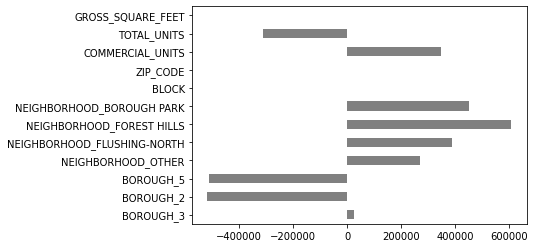

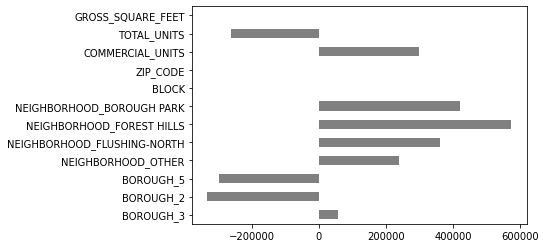

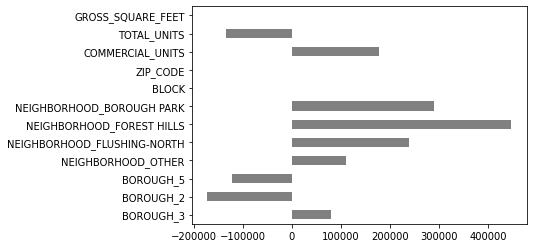

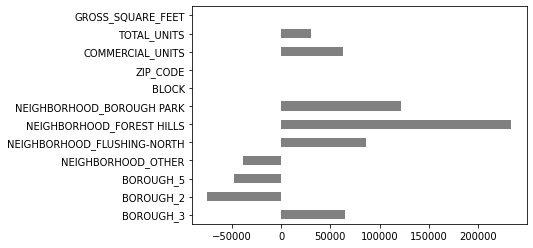

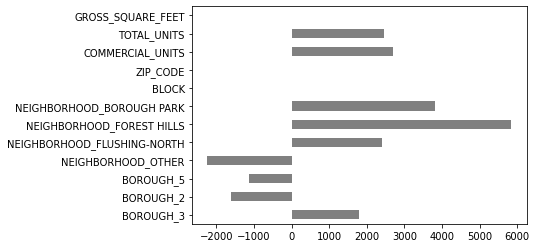

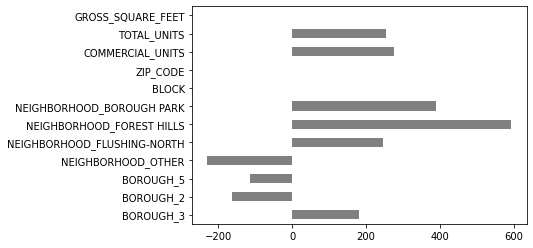

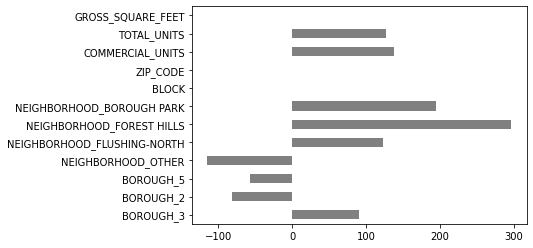

In [55]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

for alpha in [0.001, 0.01, .10, 1, 100.0, 1000.0, 2000.0]:
    
    # Fit Ridge Regression model
    display(HTML(f'Ridge Regression, with alpha={alpha}'))
    model = Ridge(alpha=alpha, normalize=True)
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)

    # Get Test MAE
    mae = mean_absolute_error(y_test, y_pred)
    display(HTML(f'Test Mean Absolute Error: ${mae:,.0f}'))
    
    # Plot coefficients
    coefficients = pd.Series(model.coef_, selected_names)
    coefficients.plot.barh(color='grey')
    plt.show()

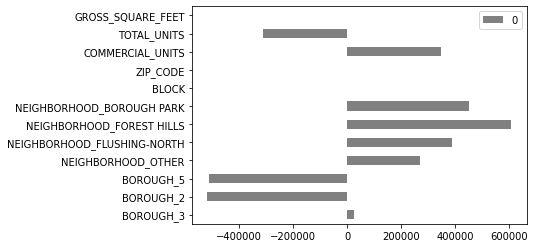

In [50]:
coefficients.plot.barh(color='grey')

In [39]:
X_train

,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_EAST NEW YORK,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_ASTORIA,BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE
44,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,5495,801,11230.0,1.0,0.0,1.0,1325.0,1930.0,1
61,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,7918,72,11427.0,1.0,0.0,1.0,2001.0,1940.0,1
78,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,4210,19,10461.0,1.0,0.0,1.0,2043.0,1925.0,1
108,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,5212,69,11226.0,1.0,0.0,1.0,2680.0,1899.0,1
111,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,7930,121,11203.0,1.0,0.0,1.0,1872.0,1940.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18129,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,4081,44,10306.0,1.0,0.0,1.0,921.0,1950.0,1
18130,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,2373,201,10314.0,1.0,0.0,1.0,2128.0,1980.0,1
18132,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,1132,42,10302.0,1.0,0.0,1.0,1807.0,2018.0,1
18134,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,3395,37,10305.0,1.0,0.0,1.0,621.0,1930.0,1




---

###Get mean absolute error for the test set.

---



In [19]:
mae = mean_absolute_error(y_test, y_pred)
print(f'The MAE of the test data is ${mae}')

The MAE of the test data is $214233.66688610442
